In [1]:
pip install datareader

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas_datareader import data as pdr
import seaborn as sns
from scipy.optimize import minimize
import multiprocessing
import time
import concurrent.futures
import threading

## Group Assignment
### Team Number: 18
### Team Member Names: Alfred Jade Jenna
### Team Strategy Chosen: SAFE 

---
## Filtering
We must filter through ``Tickers.csv`` file as not all stocks will be useful for our simulation. This data cleaning ensures that we refine the historical stock data to simulate portfolios that will be most realistic and to remove runtime errors that could occur due to lack of sufficient data. 

### We must remove tickers that:
* Are not listed in USD or CAD
* Traded below average monthly volume of 150,000 shares
* Insufficient market data for January 1 2023 to October 1 2023
* Drop months with less than 18 trading days
* Insufficient data

In [3]:
filtered_volume_list = [] # Define empty list
def read_ticker_csv(csv):
    # Load CSV into pandas DF
    ticker_df = pd.read_csv(csv)
    ticker_df.columns = ['Tickers'] # Name column
    ticker_df = ticker_df.drop_duplicates() # Dropping duplicates
    tick_list = ticker_df['Tickers'].tolist() # Creating list of ticker
    filtered_list = [] # Defining empty list

    # Function that takes in a list of ticker strings, creating a list with elements as valid tickers
    # Valid tickers must be listed in USD or CAD. The resulting list is defined as filtered_list
    def filter_valid(tickers):
        for ticker in tickers:
            try:
                temp_tick = yf.Ticker(ticker)
                if temp_tick.fast_info['currency'] == 'USD' or temp_tick.fast_info['currency'] == 'CAD':
                    filtered_list.append(ticker)
                else:
                    print(f'{ticker} is not listed in USD or CAD, therefore has been removed')
            except KeyError as error:
                    print(f'Stock {ticker} not found, Dropped. Error: {error}')

    filter_valid(tick_list)
    
    print('\n\nNow making sure each stock meets the volume and trading day requirements.\n')
    
    
    # Function to filter out the months of a stock history that have less than 18 trading days
    def filter_months(stock_history):
        # Extract the month from the 'Date' column
        stock_history['Month'] = stock_history.index.to_period('M')
        # Count the number of trading days for each month
        trading_days = stock_history.groupby('Month').size()
        # Filter out months with fewer than 18 trading days
        invalid_months = trading_days[trading_days < 18].index
        # Print message for each removed month
        for invalid_month in invalid_months:
            print(f'Data for month {invalid_month} has been removed as it has less than 18 trading days.')
        # Filter the stock history based on valid months
        filtered_stock_history = stock_history[~stock_history['Month'].isin(invalid_months)]
        # Drop the 'Month' column as it's no longer needed
        filtered_stock_history = filtered_stock_history.drop(columns='Month')
        return filtered_stock_history    
    
    # Checking to make sure each stock has a valid closing price on the Nov 24th 2023
    def has_closing_price(ticker):
        # Setting start and end date variables for the purpose of checking
        start_x = pd.to_datetime('2023-11-01')
        end_x = (datetime.now()+timedelta(days=1)).strftime('%Y-%m-%d')
        # Obtain closing history for ticker
        ticker_hist = (yf.download(ticker, start=start_x, end=end_x, threads=True)).Close
        # If date is in the index for closing history
        if '2023-11-24' in ticker_hist.index.strftime('%Y-%m-%d').tolist():
            return False # Returns false since we are using this as a case when the date is NOT found
        else:
            return True

    
    
    # Set start and end date to calculate average monthly volume for
    start_date = '2023-01-01'
    end_date = '2023-10-01'

    # For loop cycling through each ticker that was filtered for CAD and USD
    for ticker in filtered_list:
        stock_hist = yf.download(ticker, start=start_date, end=end_date, threads=True) # Get history
        if stock_hist.dropna().empty: # Drop the ticker if there is no history available
            print(f'Ticker {ticker} has no historical data and has been dropped')
        elif has_closing_price(ticker):
            print(f'Ticker {ticker} has no closing price for Nov 25th and has been dropped')
        else: # If ticker has valid history
            filtered_stock_hist = filter_months(stock_hist)
            num_months = len(filtered_stock_hist.index.to_period('M').unique())
            avg_monthly_vol = (filtered_stock_hist.Volume.sum())/num_months # Calculating the average monthly volume
            if avg_monthly_vol >= 150000:
                filtered_volume_list.append(ticker) # Add ticker to list if it passes the requirement
            else: # Print statement if not meeting requirement
                print(f'{ticker} did not meet the minimum average monthly volume requirement amd has been dropped')


    print(f'Valid Tickers: {filtered_volume_list}')
    
    
read_ticker_csv('Tickers.csv')  

Stock AGN not found, Dropped. Error: 'currentTradingPeriod'
Stock CELG not found, Dropped. Error: 'currentTradingPeriod'
Stock MON not found, Dropped. Error: 'currentTradingPeriod'
Stock RTN not found, Dropped. Error: 'currentTradingPeriod'


Now making sure each stock meets the volume and trading day requirements.

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 co

---

## Portfolio Optimization With The Monte Carlo Simulation

We use a Monte Carlo Simulation to create repeated samplings of portfolios to predict a variety of outcomes. Repeated sampling elimates error and random variables when predicting market behaviour of stocks. From the repeated samplings of our Monte Carlo simulation we can simulate portfolios of many different weights, and analyze these portfolios to see which one will give us the most returns.

### What's the Monte Carlo Simulation?

The Monte Carlo Simulation can be compared to rolling dice, instead of manually calculating the probability of each outcome, we roll the dice repeatedly to see what happens most often. This model uses computing to simulate many outcomes, the larger the sample size, the more accurate the model. That's the premise of what we're doing here, but with stock portfolios.

### Setting Up Our Portfolio Weights

Each investment in our portfolio will vary, the weight of the investment is the percentage of value in relation to the portfolio. We aim to optimize the weight of each investment in our portfolio for maximum returns. The sum of the weight of the portfolio will be 100%. Optimization will analyze which combinations of weighting of the investments will generate most returns, there are thousands of possibilities for the weightings of each stocks in our portfolio and we will investigate many.

We do this part with code that looks like this:

```python
weights = np.random.random(size=n)
weights /= np.sum(weights)
```

This code randomly picks the weights for us and then makes sure they add up to 100%.

### How Do We Choose the Best Portfolio?

To figure out which portfolio is the best, we use something called the **Sharpe Ratio**. It represents the returns that can be made per unit risk. But since we're feeling daring, we tweak it a bit. We want a portfolio that's not just going to make us money, but one that could make us a LOT of money, even if it's a bit riskier.

### A Twist on the Sharpe Ratio: The Risk Coefficient

The Sharpe Ratio formula looks like this:

$$
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
$$


- \($R_p$) is how much return we think we'll get from our portfolio.
- \($R_f$) is what we'd get from a super safe investment (we often just set this to zero).
- \($\sigma_p$) is how much our portfolio's returns might go up and down.

But for us, we want to celebrate the ups and downs because they mean more potential for big wins. So, we make a new formula that rewards a bumpy ride:

$$
\text{Risk Coefficient} = (\text{Sharpe Ratio}) \times (\sigma_p)^2
$$
Now, the bumpier the ride (the higher the $\sigma_p$), the better, according to our new rule. We square the volatility to really focus on those big swings.

### Running the Numbers

From the preprocessed data, we calculate annualized return, annualized volatility, and the sharpe ratio. These statistics help us better understand the nature of the risks and returns of the stocks in our list of tickers. These statistics will help us simulate the performance of the stocks, and choose the stocks that will generate the highest returns in our portfolio.
Annualized volatility is a quantifier of risk of a stock, it represents the volatility of the share price over time. A stock which has high annualized volatility is considered risky because the prices fluxuate greatly annually, meaning the stock can generate high losses or returns quickly. The Sharpe Ratio quantifies risk the relationship betweens risk and return of a stock. The Sharpe Ratio is a tool to calculate investment return per risk. The higher the ratio the better - signalling that the investment will have greater returns per unit risk. We simulate a lot (like, thousands) of different portfolios with all sorts of weight combinations. For each one, we calculate our new Risk Coefficient. We choose the portfolio with the highest risk coefficient to maximize on our portfolios returns. Our strategy that favours risk focuses on the most volatile stocks, which can provide us with the most returns in a short time frame of 5 trading days.

### Variance
* Variance is a measure of how dispersed data points are from their average value. This is used to examine how volatile a stocks are, if they have high variance then they are an indicator of a risky stock. High vairance indicated that a stocks value is distant from the average values, indicating variability. 
  
$$
\sigma^2 = \frac{\sum_{i=1}^{n}(x_i - \mu)^2} {n}
$$
### Covariance
* Covariance is a measure of the correlation between two data sets. We use them to measure the change in a stocks returns in relation to the change in a markets returns. Covariance is a vector quantity, the magnitude indicated how strong the correlation is, and -/+ indicated wether its a negative or positive correlation. Covariance is particularly useful for determining the beta's of stocks in relation to the market.
$$
cov_{x,y}=\frac{\sum_{i=1}^{N}(x_{i}-\bar{x})(y_{i}-\bar{y})}{N-1}
$$

### Beta
* Beta is a measure of volatility or risk. It asseses a stocks performance in relation to the market, in doing so it asseses *systemic risk*, the risk which is inherent to the market and cannot be diversified away. Beta represents how a stock will behave in the market. We're seeking for big swings in our porfolio and we will use beta calculations to increase our chances of high returns.  
$$
\beta = \frac{\text cov(R_s,R_m)}{\text var(R_m)}
$$

- \($R_s$) are stock returns
- \($R_m$) are market returns

In [4]:
# Define dates
start_date = '2023-01-01'
end_date = '2023-11-25'

In [5]:
# Constants
tickers = filtered_volume_list
max_stocks = 22  # Maximum number of stocks
min_stocks = 10  # Minimum number of stocks
MarketIndex = "^GSPC"  # S&P 500 as the market index

 
# Fetch historical data for the market index
market_hist = yf.Ticker(MarketIndex).history(start=start_date, end=end_date).filter(like="Close")
market_hist["Returns"] = market_hist["Close"].pct_change() * 100

market_var = market_hist["Returns"].var()

# Function to calculate beta for a stock
def get_stock_beta(stock_ticker, marketVar=market_var):
    stock_hist = yf.Ticker(stock_ticker).history(start=start_date, end=end_date)['Close'].dropna().pct_change() * 100
    binary_portfolio = pd.DataFrame({'Market': market_hist["Returns"], 'Stock': stock_hist})
    beta = (binary_portfolio.cov() / marketVar)['Stock'].loc["Market"]
    return beta

# func to calc additional factors (e.g., volatility, mean returns, etc.) for a stock
def calculate_factors(stock_ticker):
    stock_hist = yf.Ticker(stock_ticker).history(start=end_date, end=end_date)['Close']
    stock_hist = stock_hist.dropna()
    returns = stock_hist.pct_change() * 100
    volatility = returns.std()
    mean_return = returns.mean()
    # Add more factors as needed
    return volatility, mean_return

# calc beta values and additional factors for all tickers
stock_factors = {}
for ticker in tickers:
    beta = get_stock_beta(ticker)
    volatility, mean_return = calculate_factors(ticker)
    stock_factors[ticker] = {
        'Beta': beta,
        'Volatility': volatility,
        'MeanReturn': mean_return
    }

# define a scoring function to rank stocks based on multiple factors
def score_stock(stock):
    # Customize the scoring logic as per your preferences
    return stock['Beta'] + stock['Volatility'] - stock['MeanReturn']

# sort the tickers based on the score
sorted_tickers = sorted(tickers, key=lambda ticker: score_stock(stock_factors[ticker]), reverse=True)

# choose between 10 and 22 stocks
selected_tickers = sorted_tickers[:max_stocks] if len(sorted_tickers) >= max_stocks else sorted_tickers[:min_stocks]

print("Selected Tickers based on Enhanced Strategy:")
print(selected_tickers)

ABBV: No price data found, symbol may be delisted (1d 2023-11-25 -> 2023-11-25)
ABT: No price data found, symbol may be delisted (1d 2023-11-25 -> 2023-11-25)
ACN: No price data found, symbol may be delisted (1d 2023-11-25 -> 2023-11-25)
AIG: No price data found, symbol may be delisted (1d 2023-11-25 -> 2023-11-25)
AMZN: No price data found, symbol may be delisted (1d 2023-11-25 -> 2023-11-25)
AXP: No price data found, symbol may be delisted (1d 2023-11-25 -> 2023-11-25)
BA: No price data found, symbol may be delisted (1d 2023-11-25 -> 2023-11-25)
BAC: No price data found, symbol may be delisted (1d 2023-11-25 -> 2023-11-25)
BIIB: No price data found, symbol may be delisted (1d 2023-11-25 -> 2023-11-25)
BK: No price data found, symbol may be delisted (1d 2023-11-25 -> 2023-11-25)
BLK: No price data found, symbol may be delisted (1d 2023-11-25 -> 2023-11-25)
BMY: No price data found, symbol may be delisted (1d 2023-11-25 -> 2023-11-25)
C: No price data found, symbol may be delisted (1d 

Selected Tickers based on Enhanced Strategy:
['ABBV', 'ABT', 'ACN', 'AIG', 'AMZN', 'AXP', 'BA', 'BAC', 'BIIB', 'BK', 'BLK', 'BMY', 'C', 'CAT', 'CL', 'KO', 'LLY', 'LMT', 'MO', 'MRK', 'PEP', 'PFE']


In [6]:
# Constants
cash = 750000  # Total budget in CAD
fee_per_stock = 4.95  # Flat fee per stock in CAD
risk_free_rate = 0.02  # Risk-free rate (e.g., Treasury yield)
selected_tickers = sorted(selected_tickers)
mc_weights = []
type_currency = pd.DataFrame(selected_tickers)
Portfolio_Final = pd.DataFrame(index=range(1, len(selected_tickers) + 1))
portfolio = pd.DataFrame()
portfolio_shares = {}
portfolio_metrics = []  # Store portfolio metrics for all simulations
data = yf.download(selected_tickers, start=start_date, end=end_date, threads=True)['Adj Close']

def get_portfolio_weights(num_stocks, max_weight=0.20):
    # Generate random weights for the given number of stocks
    weights = np.random.random(num_stocks)
    # Normalize the weights so they sum up to 1
    weights /= np.sum(weights)
    # Apply the maximum weight limit and renormalize
    weights = np.minimum(weights, max_weight)
    weights /= np.sum(weights)
    return weights

def simulate(_):
    # Generate random portfolio weights
    weights = get_portfolio_weights(len(selected_tickers))

    # Data preprocessing to handle missing values
    data.dropna(how='all', inplace=True)
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)

    portfolio = pd.DataFrame(index=data.index)
    portfolio_shares = {}
    total_spent = 0

    # Calculate the number of shares to buy for each stock based on portfolio weights
    for i, ticker in enumerate(selected_tickers):
        allocation = weights[i] * (cash - len(selected_tickers) * fee_per_stock)
        initial_ticker_price = data[ticker].iloc[0]
        shares = allocation / initial_ticker_price
        portfolio_shares[ticker] = shares
        total_spent += shares * initial_ticker_price + fee_per_stock

    # Adjust the weights if the total allocation exceeds the budget
    if total_spent > cash:
        scale_factor = cash / total_spent
        for ticker in selected_tickers:
            portfolio_shares[ticker] *= scale_factor
        total_spent = sum(portfolio_shares[ticker] * data[ticker].iloc[0] for ticker in selected_tickers) + len(selected_tickers) * fee_per_stock

    # Construct the portfolio
    for ticker in selected_tickers:
        portfolio[ticker] = portfolio_shares[ticker] * data[ticker]

    portfolio['Total Value'] = portfolio.sum(axis=1)
    initial_portfolio_value = portfolio['Total Value'].iloc[0]
    total_portfolio_value = portfolio['Total Value'].iloc[-1]

    # Recalculate the final weights based on the final value of each stock
    final_weights = {ticker: (portfolio_shares[ticker] * data[ticker].iloc[-1]) / total_portfolio_value for ticker in selected_tickers}

    portfolio['Percent Return'] = portfolio['Total Value'].pct_change() * 100
    std = portfolio['Percent Return'].std()
    avg_return = portfolio['Percent Return'].mean()
    excess_return = avg_return - risk_free_rate
    risk_coefficient = (excess_return / std) * (std**2)  # Risk coefficient with a twist

    # Store portfolio metrics
    portfolio_metrics.append({
        'Weights': final_weights,
        'Risk Coefficient': risk_coefficient,
        'Portfolio Shares': portfolio_shares,
        'Final Portfolio Value': total_portfolio_value
    })

def monte_carlo_portfolio_optimization(num_portfolios, start_date, end_date, ticker_list, risk_free_rate=risk_free_rate):
    sss = time.time()
    
    # Loop that checks for the currency of each ticker. If it is USD it is converted to CAD
    # Our portfolio standard currency is in CAD
    for ticker in list(data.columns):
        temp = yf.Ticker(ticker)
        cur = temp.fast_info['currency']
        if cur == 'USD':
            rate = yf.download('USDCAD=x', start=start_date, end=end_date, threads=True)['Close']
            data[ticker] = data[ticker] * rate
    
    # Threading
    # Ensuring that script is being run at top level
    if __name__ == "__main__":
        num_threads =  4 # Can be adjusted
        num_iterations = num_portfolios    
        # Create a list to store thread objects
        threads = []

        # Define the function to be executed in each thread
        def run_thread(start, end):
            for i in range(start, end):
                simulate(i)

        # Calculate the number of iterations each thread will handle
        iterations_per_thread = num_iterations // num_threads

        # Create and start threads
        for i in range(num_threads):
            start = i * iterations_per_thread
            end = (i + 1) * iterations_per_thread if i < num_threads - 1 else num_iterations
            thread = threading.Thread(target=run_thread, args=(start, end))
            threads.append(thread)
            thread.start()

        # Wait for all threads to complete
        for thread in threads:
            thread.join()
    else:
        print('Error: Please ensure script is being run at top level.')
    
    eee = time.time()
    elapsed_time = sss - eee
    print(f"Total runtime: {elapsed_time} seconds")
    # sort portfolios by Risk Coefficient and get the best portfolio
    portfolio_metrics.sort(key=lambda x: x['Risk Coefficient'], reverse=True)
    best_portfolio = portfolio_metrics[0]

    
    type_currency.index = type_currency.index + 1
    # create the Portfolio_Final DataFrame for the best portfolio
    Portfolio_Final['Ticker'] = ticker_list
    Portfolio_Final['Price'] = data.iloc[-1].values
    Portfolio_Final['Currency'] = 'CAD'
    Portfolio_Final['Shares'] = [best_portfolio['Portfolio Shares'][ticker] for ticker in ticker_list]
    Portfolio_Final['Value'] = Portfolio_Final['Shares'] * Portfolio_Final['Price']
    Portfolio_Final['Weight'] = [best_portfolio['Weights'][ticker] * 100 for ticker in ticker_list]  # Convert to percentage

    # print the best portfolio and metrics
    print("Best Portfolio:")
    print(Portfolio_Final)
    print("Risk Coefficient (Twisted):", best_portfolio['Risk Coefficient'])
    print("Portfolio Shares:", best_portfolio['Portfolio Shares'])
   
    return [best_portfolio['Weights'], best_portfolio['Risk Coefficient'], best_portfolio['Final Portfolio Value']]

# Usage
# Define the dates for the simulation
num_portfolios = 20000  # Number of portfolio simulations

# Run the Monte Carlo portfolio optimization simulation
mc_results = monte_carlo_portfolio_optimization(num_portfolios, start_date, end_date, selected_tickers)
mc_weights, mc_risk_coefficient, mc_final_value = mc_results

# print the sum of weights to verify it does not exceed 100%
sum_of_weights = sum(mc_weights.values())
print("Sum of Weights:", sum_of_weights)

[*********************100%%**********************]  22 of 22 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*****

## Risk-Focused Portfolio Optimization Using SLSQP

### The Core Idea

Our primary goal is to maximize the expected returns of the portfolio. This is a shift from the traditional method of maximizing the Sharpe Ratio, which considers both returns and volatility (risk). By focusing solely on returns, we're gearing up for a more aggressive investment stance.
### How Do We Achieve This?

We use an optimization algorithm known as Sequential Least SQuares Programming (SLSQP), but with a twist:

* **Objective Function - Maximize Returns**: The heart of our method is the objective function. Instead of the Sharpe Ratio, we use the portfolio's expected return as our guiding star. Our aim is to find the combination of stock weights that gives us the highest possible return.

* **Constraints - Keeping It Real**: We still have rules to follow. The sum of the weights of all stocks in our portfolio must equal 100%. This ensures our portfolio is fully allocated across our chosen stocks.

* **Bounds - Flexibility Within Limits**: Each stock can only take up a certain percentage of our portfolio (between 1% and 22%). This prevents putting all our eggs in one or few baskets, which is a basic risk management principle.

### The Optimization Process

Here's how the process unfolds:

* **Data Gathering**: We pull historical data for our selected stocks to understand their past performance.

* **Calculating Returns**: We focus on the average daily returns of these stocks, as these will be the backbone of our return maximization strategy.

* **Running the Optimization**: With our objective function set to maximize returns, the SLSQP algorithm gets to work. It intelligently navigates through various weight combinations, seeking the one that promises the highest return.

* **Result Analysis**: The output is a set of weights for each stock in our portfolio that theoretically offers the highest returns based on historical data.



In [7]:
# Constants
cash = 750000  # Total budget in CAD
fee_per_stock = 4.95  # Flat fee per stock in CAD
risk_free_rate = 0.02  # Risk-free rate (e.g., Treasury yield)
tickers = selected_tickers
start_sl='2020-01-01'
end_sl='2023-01-01'


# fetching historical stock data from Yahoo Finance. We're looking at data from 2020 to 2023.
# this data will help us figure out how these stocks have performed in the past.
data = yf.download(tickers, start=start_sl, end=end_sl, threads=True)['Adj Close']

# Loop that checks for the currency of each ticker. If it is USD it is converted to CAD
# Our portfolio standard currency is in CAD
for ticker in list(data.columns):
    temp = yf.Ticker(ticker)
    cur = temp.fast_info['currency']
    if cur == 'USD':
        rate = yf.download('USDCAD=x', start=start_sl, end=end_sl, threads=True)['Close']
        data[ticker] = data[ticker] * rate

# calculating daily percentage changes in stock prices. This tells us how much each stock's price
# has changed from one day to the next.
returns = data.pct_change().dropna()

# defining a function to calculate the total return of our portfolio based on the weights of each stock.
# it multiplies each stock's average daily return by its weight and adds them up.
# we multiply by 252 because there are 252 trading days in a year, turning our daily return into an annual one.
def portfolio_return(weights):
    return np.sum(returns.mean() * weights) * 252

# our objective function, which we want to maximize. In optimization terms, we usually talk about minimizing,
# so we take the negative of our portfolio return. The optimizer will minimize this negative return,
# which is the same as maximizing the positive return.
def negative_portfolio_return(weights):
    return -portfolio_return(weights)

# setting up our constraints. We want the sum of our weights to be 1, meaning we use all our money.
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# setting bounds for our weights. Each stock can only take up between 1% and 22% of our portfolio.
# this prevents us from putting too much into any one stock (diversification is key!).
bounds = tuple((0.01, 0.22) for _ in tickers)

# our initial guess for the weights. We start off evenly distributed, but the optimizer will adjust this.
initial_guess = np.random.random(len(tickers))
initial_guess /= np.sum(initial_guess)

# running the optimization! We use the SLSQP method to minimize our negative return function.
# the optimizer will change the weights around to find the combination where our negative return is as low as possible.
result = minimize(negative_portfolio_return, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

# if the optimization didn't work out, we'll know here.
if not result.success:
    raise ValueError("Optimization did not converge. Please check the setup and data.")

# finally, our optimal weights. These are the weights that the optimizer found to give us the highest return.
optimal_weights = result.x

# calculate the number of shares to buy for each stock based on the optimal weights and cash available
portfolio_shares = {}
total_spent = 0

for i, ticker in enumerate(tickers):
    stock_price = data[ticker].iloc[-1]  # Get latest stock price
    allocation = cash * optimal_weights[i]  # Calculate the allocation for each stock
    shares = (allocation - fee_per_stock) / stock_price  # Calculate the number of shares
    portfolio_shares[ticker] = shares
    total_spent += shares * stock_price + fee_per_stock

# ensure that the total spent is within the budget
# check if the total spent is within the budget, considering the fee for each stock
if total_spent > cash:
    excess_amount = total_spent - cash
    print(f"Warning: The budget was exceeded by {excess_amount:.2f} CAD.")
    print("Adjusting the portfolio to stay within budget.")
    
    # calculate the adjustment factor to bring the total spent back to the budget
    adjustment_factor = (cash - fee_per_stock * len(tickers)) / total_spent
    
    # adjust the number of shares and total spent for each stock
    for ticker in tickers:
        portfolio_shares[ticker] *= adjustment_factor
    total_spent = cash
    
    print("Portfolio adjusted successfully.")


# calculate the total portfolio value
portfolio_value = sum(portfolio_shares[ticker] * data[ticker].iloc[-1] for ticker in tickers)


# create the Portfolio_Final2 DataFrame as per the given rules
Portfolio_Final2 = pd.DataFrame(index=range(1, len(tickers) + 1))
Portfolio_Final2['Ticker'] = tickers
Portfolio_Final2['Price'] = [data[ticker].iloc[-1] for ticker in tickers]
Portfolio_Final2['Currency'] = 'CAD'
Portfolio_Final2['Shares'] = [portfolio_shares[ticker] for ticker in tickers]
Portfolio_Final2['Value'] = [portfolio_shares[ticker] * data[ticker].iloc[-1] for ticker in tickers]
Portfolio_Final2['Weight'] = optimal_weights*100

# print the Portfolio_Final2 DataFrame
print("Portfolio_Final:")
print(Portfolio_Final2)

# print the total portfolio value and total weights (should sum to 100%)
print("Total Portfolio Value:", portfolio_value)
print("Total Weight:", sum(Portfolio_Final2['Weight']))

# finally, print the optimized weights
print("Optimal Portfolio Weights for a Risky Approach: ")
print(dict(zip(tickers, optimal_weights*100)))

# store SLSQP weights in list
slsqp_weights = optimal_weights*100

[*********************100%%**********************]  22 of 22 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*****

/Users/aj/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/aj/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/aj/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/aj/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/aj/anaconda3/lib/python3.11/site-packages/scipy/optimize/_opt

## Choosing The Final Portfolio
By simulating many outcomes of portfolios of investments from the csv ticker file with the Monte Carlo and SLSQP Simulations we can model how stocks will perform in the future. We choose the portfolio with the highest returns and we will base our final portfolio off of the best model. We hope that the final portfolio will perform realistically to the simulation.

### Why We Chose The Portfolio
* **Modeling our investment period** Monte Carlo and SLSQP portfolios simulate short 1-2 week investment because that is how long our investment will run for.

* **Most Relevant Market Data** Used market data from January 1 2023 - November 25 2023 for data most relevant to our investment, short term investments like ours follow recent trends, old data wouldnt be as similar as recent data.

* **Large Sample Size** Large sample size in each simulation reduces error and improves accuracy, we can trust the reliability of our portfolio.

* **Optimizating Weights** Optimizing portfolio weights for highest returns ensures that our investments maximize returns.

* **Using Statistics (Covariance, $\beta$, Sharpe Ratio)** Analyzing the market data has ensured that we have evaluated the risk of our portfolio, and the risk-adjusted returns of the investments. We've used these calculations in our simulations in our selections of weights and tickers to optimize our risk for reward, while focusing on volatile stocks that will give us large returns in less than a week.
  
The data from these models are meaningful to us because we used data that was cleaned for high quality results, and used data from January 1, 2023 to the present day for our simulations so the results would emulate the markets most realistically. We eliminated random error by using a large sample size for both simulations decreasing variability for most accurate results. We assesed the best option for our final portfolio by quantifying risk and returns by calculating statistics like annualized returns and volatility. We used to Sharpe Ratio and Risk Coefficient to asses portfolios to optimize risk and returns. We chose a risky strategy because of the 5 day trading simulation our portfolio will run for, we need to ensure our stocks have some volatility, because our trading period is short.

We have chosen individual stocks based off of their volatility, and the returns we will receive for the risk of investment. We want to maximize our gains over the 5 day trading period, we have optimized the weightings of the portfolio based off if the best performing simulation. The analysis of thousands of possible weightings for our portfolio ensures that we have selected the best weighting available. Simulating outcomes of portfolios for a large sample size improves accuracy and gives us a better result with each simulation, comparing the different simulations reduces margin for systemic error and reinforces decision making for the investments. 

Our Monte Carlo Simulation generated a better portfolio weighting. We will base our investments on this simulation


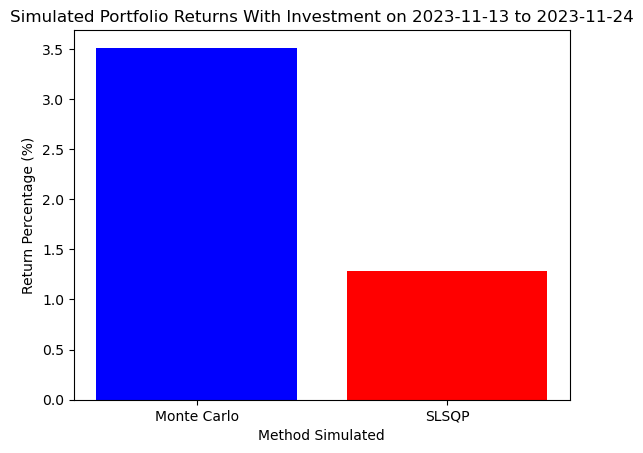


Optimized Portfolio:


,Ticker,Price,Currency,Shares,Value,Weight
1,ABBV,189.908568,CAD,161.161011,30605.856769,4.081441
2,ABT,140.880473,CAD,170.759234,24056.641655,3.208212
3,ACN,457.467805,CAD,115.381157,52783.164490,7.038415
4,AIG,88.824885,CAD,301.335728,26766.111515,3.569475
5,AMZN,200.960444,CAD,611.431251,122873.495313,16.383793
6,AXP,224.448071,CAD,45.593059,10233.274256,1.365097
7,BA,301.290009,CAD,281.437184,84794.211668,11.306555
8,BAC,40.392846,CAD,1144.785504,46241.144429,6.166146
9,BIIB,317.655530,CAD,93.523980,29708.409590,3.961781
10,BK,64.845825,CAD,442.036633,28664.230106,3.822557



Total Portfolio Value + Trading Fees: 749999.9999999999


Total Portfolio Weight: 99.99999999999999


In [8]:
# Define variables for total cash and optimized weightings from two methods above
total_cash = 750000
weight1 = mc_weights.values()
weight2 = slsqp_weights
mc = None
sl = None
trd_fee = 4.95

# Define amount of cash to be invested per stock based on weightings
amount1 = [total_cash * weight for weight in weight1]
amount2 = [total_cash * weight for weight in weight2]

# Get simulation investment dates, two weeks from today and one day from today
investment_date = pd.to_datetime('2023-11-11')
selling_date = pd.to_datetime('2023-11-25')
last_market = None
# Define placeholders
hist_df = pd.DataFrame()
portfolio1 = pd.DataFrame()
portfolio2 = pd.DataFrame()
first_market_day = ''
last_market_day = ''

# Loop that gets stock history for each ticker, adding close price to DataFrame
for ticker in selected_tickers:
    temp = yf.Ticker(ticker)
    temp_hist = temp.history(start=investment_date, end=selling_date)
    first_market_day = temp_hist.index.strftime('%Y-%m-%d')[0]
    last_market_day = temp_hist.index.strftime('%Y-%m-%d')[-1]
    last_market = (pd.to_datetime(temp_hist.index[-1])+timedelta(days=1)).strftime('%Y-%m-%d')
    hist_df[ticker] = temp_hist.Close

# Getting amount of shares to be purchased for each stock for each optimization scheme
shares1 = [amount / cost for amount,cost in zip(amount1, list(hist_df.iloc[0]))]
shares2 = [amount / cost for amount,cost in zip(amount2, list(hist_df.iloc[0]))]

# Multiplying stock prices by share number to simulate investment
i = 0
for tick in list(hist_df.columns):
    portfolio1[tick] = hist_df.iloc[:,i] * shares1[i]
    portfolio2[tick] = hist_df.iloc[:,i] * shares2[i]
    i+=1

# Calculate starting/ending portfolio total values and profit for both methods to simulate investment
starting_port_1 = sum(portfolio1.iloc[0])
end_port_1 = sum(portfolio1.iloc[-1])
profit1 = end_port_1 -starting_port_1

starting_port_2 = sum(portfolio2.iloc[0]/100)
end_port_2 = sum(portfolio2.iloc[-1]/100)
profit2 = end_port_2 -starting_port_2

# Get return percentages for graph
mc_return = ((end_port_1/starting_port_1)-1)*100
sl_return = ((end_port_2/starting_port_2)-1)*100
returns = ['Monte Carlo', 'SLSQP']
return_val = [mc_return, sl_return]

# Finalize which method to be used. If the goal is to maximize profit it should read 'profit1 >= profit2'
# If goals are to remain as close to 0% change, it should read 'profit2 >= profit2'
if profit1 >= profit2:
    mc = True
    print(f'Our Monte Carlo Simulation generated a better portfolio weighting. We will base our investments on this simulation')
else:
    sl = True
    print(f'Our SLSQP generated a better portfolio weighting. We will base our investments on this optimization')

# Plot bar graph to show the percentage returns of each method
plt.bar(returns, return_val, color=['blue', 'red'])
plt.title(f'Simulated Portfolio Returns With Investment on {first_market_day} to {last_market_day}')
plt.ylabel('Return Percentage (%)')
plt.xlabel('Method Simulated')
plt.show()

# Now we will display the optimized portfolio, using close prices of today or latest market day
print('\nOptimized Portfolio:')

# Get exchange rate for same day
rate = (yf.Ticker('USDCAD=X').history(start=last_market_day,end=last_market)).Close[0]

# Placeholder for stock prices
prices = []

# Case if Monte Carlo is best portfolio
if mc:
    # Create dataframe to store Ticker, Prices (in cad), Currency, Shares, Value, and weight
    Final_Portfolio = pd.DataFrame()
    Final_Portfolio['Ticker'] = Portfolio_Final['Ticker']
    for ticker in list(Final_Portfolio['Ticker']):
        temp = yf.Ticker(ticker)
        cur = temp.fast_info['currency']
        # If the currency of the stock is in USD we will convert it to CAD
        if cur == 'USD':
            prices.append(temp.history(start=last_market_day,end=last_market).Close[0] * rate)
        else:
            prices.append(temp.history(start=last_market_day,end=last_market).Close[0])
    Final_Portfolio['Price'] = prices
    Final_Portfolio['Currency'] = Portfolio_Final['Currency']
    Final_Portfolio['Shares'] = (((Portfolio_Final['Weight']/100)*total_cash)-trd_fee)/prices
    Final_Portfolio['Value'] = (((Portfolio_Final['Weight']/100)*total_cash)-trd_fee)
    Final_Portfolio['Weight'] = Portfolio_Final['Weight']
    display(Final_Portfolio.style.set_caption('Final Optimized Portfolio Using Monte Carlo Simulation'))
    # Double check that portfolio adds to $750000 and weight adds to 100%
    print(f"\nTotal Portfolio Value + Trading Fees: {sum(Final_Portfolio['Value'])+len(Final_Portfolio.index)*trd_fee}\n\n")
    print(f"Total Portfolio Weight: {sum(Final_Portfolio['Weight'])}")
    
# Case if SLSQP is best portfolio
else:
    # Create dataframe to store Ticker, Prices (in cad), Currency, Shares, Value, and weight
    Final_Portfolio = pd.DataFrame()
    Final_Portfolio['Ticker'] = Portfolio_Final2['Ticker']
    for ticker in list(Final_Portfolio['Ticker']):
        temp = yf.Ticker(ticker)
        cur = temp.fast_info['currency']
        # If the currency of the stock is in USD we will convert it to CAD
        if cur == 'USD':
            prices.append(temp.history(start=last_market_day,end=last_market).Close[0] * rate)
        else:
            prices.append(temp.history(start=last_market_day,end=last_market).Close[0])
    Final_Portfolio['Price'] = prices
    Final_Portfolio['Currency'] = Portfolio_Final2['Currency']
    Final_Portfolio['Shares'] = (((Portfolio_Final2['Weight']/100)*total_cash)-trd_fee)/prices
    Final_Portfolio['Value'] = (((Portfolio_Final2['Weight']/100)*total_cash)-trd_fee)
    Final_Portfolio['Weight'] = Portfolio_Final2['Weight']
    # Display optimal portfolio
    display(Final_Portfolio.style.set_caption('Final Optimized Portfolio Using SLSQP Method'))
    # Double check that portfolio adds to $750000 and weight adds to 100%
    print(f"\nTotal Portfolio Value + Trading Fees: {sum(Final_Portfolio['Value'])+len(Final_Portfolio.index)*trd_fee}\n\n")
    print(f"Total Portfolio Weight: {sum(Final_Portfolio['Weight'])}")



### Creating Stocks_Final DataFrame and Exporting to CSV file

In [9]:
# Create Stocks_Final DataFrame 
Stocks_Final = Final_Portfolio[['Ticker', 'Shares']]

# Exporting Stocks_Final DataFrame to CSV file
Stocks_Final.to_csv('Stocks_Group_18.csv')

Stocks_Final

,Ticker,Shares
1,ABBV,161.161011
2,ABT,170.759234
3,ACN,115.381157
4,AIG,301.335728
5,AMZN,611.431251
6,AXP,45.593059
7,BA,281.437184
8,BAC,1144.785504
9,BIIB,93.523980
10,BK,442.036633
